In [809]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2
from pycocotools.coco import COCO

# Other Imports
from tqdm.notebook import tqdm

import json

LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

In [810]:
miss_annotation_id_lists = []
miss_image_id_lists = []

In [811]:
file_path = './trimtrain.json'

coco = COCO(file_path)

with open(file_path, "r") as json_file:
    json_data = json.load(json_file)
    print(json_data)
    
    
train_df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
annid = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
        
    file_name = image_info['file_name']
        
    for ann in anns:
        image_ids.append(file_name)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))
        annid.append(ann['id'])

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max
train_df['ann_id'] = annid

train_df['area'] = ((train_df['y_max'] - train_df['y_min'])*(train_df['x_max'] - train_df['x_min']))
train_df['invarea'] = 1/((train_df['y_max'] - train_df['y_min'])*(train_df['x_max'] - train_df['x_min']))
train_df['whratio'] = (train_df['x_max'] - train_df['x_min']) / (train_df['y_max'] - train_df['y_min'])
train_df['hwratio'] = (train_df['y_max'] - train_df['y_min']) / (train_df['x_max'] - train_df['x_min'])



loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [812]:
train_df.tail(10)

,image_id,class_name,class_id,x_min,y_min,x_max,y_max,ann_id,area,invarea,whratio,hwratio
22644,train/4880.jpg,General trash,0,193.3,209.2,769.7,846.6,23134,367397.36,0.000003,0.904299,1.105829
22645,train/4881.jpg,Plastic bag,7,114.5,45.2,866.2,518.1,23135,355478.93,0.000003,1.589554,0.629107
22646,train/4881.jpg,Plastic bag,7,724.0,69.1,769.0,111.8,23136,1921.50,0.000520,1.053864,0.948889
22647,train/4881.jpg,Paper,1,279.0,459.7,443.6,567.9,23137,17809.72,0.000056,1.521257,0.657351
22648,train/4881.jpg,Plastic bag,7,151.4,484.8,691.5,858.9,23138,202051.41,0.000005,1.443732,0.692650
22649,train/4882.jpg,Plastic,5,0.0,116.2,944.1,930.3,23139,768591.81,0.000001,1.159686,0.862303
22650,train/4882.jpg,Plastic bag,7,302.1,439.3,567.3,655.4,23140,57309.72,0.000017,1.227210,0.814857
22651,train/4882.jpg,General trash,0,511.3,451.1,570.0,481.3,23141,1772.74,0.000564,1.943709,0.514480
22652,train/4882.jpg,Paper,1,255.0,421.4,526.7,616.5,23142,53008.67,0.000019,1.392619,0.718071
22653,train/4882.jpg,Paper,1,145.4,295.4,565.6,651.5,23143,149633.22,0.000007,1.180006,0.847454


In [813]:
train_df.where(train_df['class_name'] == 'Battery').value_counts()

image_id        class_name  class_id  x_min  y_min  x_max   y_max  ann_id   area      invarea   whratio   hwratio 
train/0092.jpg  Battery     8.0       220.7  394.3  730.6   516.4  426.0    62258.79  0.000016  4.176085  0.239459    1
train/2763.jpg  Battery     8.0       531.0  529.5  631.6   747.9  13037.0  21971.04  0.000046  0.460623  2.170974    1
train/2139.jpg  Battery     8.0       377.2  497.0  783.5   735.5  10194.0  96902.55  0.000010  1.703564  0.587005    1
train/2187.jpg  Battery     8.0       336.9  627.6  469.3   684.5  10395.0  7533.56   0.000133  2.326889  0.429758    1
                                      584.1  462.2  660.6   562.8  10396.0  7695.90   0.000130  0.760437  1.315033    1
                                                                                                                     ..
train/0949.jpg  Battery     8.0       769.0  601.9  1023.6  720.8  4593.0   30271.94  0.000033  2.141295  0.467007    1
                                      801.5  

In [814]:
battery_image_id_lists = ((train_df.loc[train_df['class_name'] == 'Battery'])['image_id'].values.tolist())
others_image_id_lists = ((train_df.loc[train_df['class_name'] != 'Battery'])['image_id'].values.tolist())
battery_image_id_lists = list(set(battery_image_id_lists))
others_image_id_lists = list(set(others_image_id_lists))

In [815]:
import random

random.shuffle(battery_image_id_lists)
random.shuffle(others_image_id_lists)

In [816]:
T = 3
V = 1

In [817]:
samplelen = len(battery_image_id_lists)
idx = int(samplelen * (T/(T+V)))

train_image_id_lists = battery_image_id_lists[:idx]
val_image_id_lists = battery_image_id_lists[idx:]

In [818]:
samplelen = len(others_image_id_lists)
idx = int(samplelen * (T/(T+V)))

train_image_id_lists.extend(others_image_id_lists[:idx])
val_image_id_lists.extend(others_image_id_lists[idx:])

In [819]:
train_image_id_lists = set(train_image_id_lists)
val_image_id_lists = set(val_image_id_lists)
print(len(train_image_id_lists))
print(len(val_image_id_lists))

intersections = train_image_id_lists &  val_image_id_lists
intersections

3656
1223


{'train/0635.jpg',
 'train/0643.jpg',
 'train/1175.jpg',
 'train/1861.jpg',
 'train/3122.jpg',
 'train/3930.jpg',
 'train/4087.jpg'}

In [820]:
for intersection in intersections:
    train_image_id_lists.remove(intersection)

In [821]:
print(len(train_image_id_lists))
print(len(val_image_id_lists))

3649
1223


In [822]:
train_df['dataset'] = 0
for idx in train_df.index:
    if(train_df.loc[idx,'image_id'] in train_image_id_lists):
        train_df.loc[idx,'dataset'] = 'Train'
    else:
        train_df.loc[idx,'dataset'] = 'Val'

In [823]:
TrainDataset_df = train_df.loc[train_df['dataset'] == 'Train']
ValDataset_df = train_df.loc[train_df['dataset'] == 'Val']

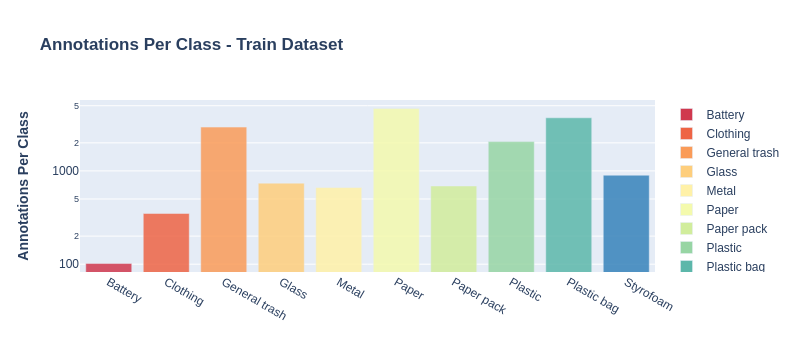

In [835]:
fig = px.bar(TrainDataset_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class - Train Dataset</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

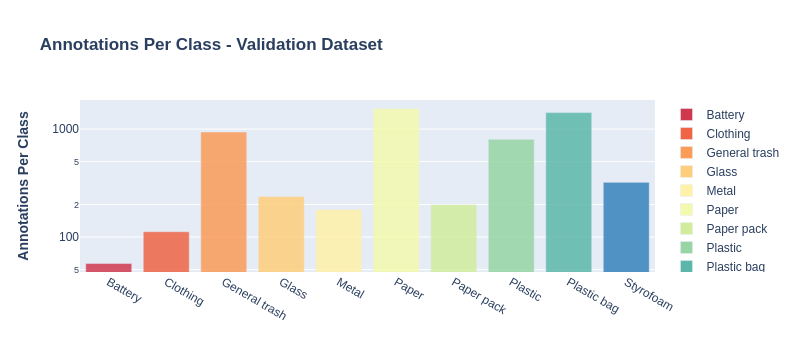

In [836]:
fig = px.bar(ValDataset_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class - Validation Dataset</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

In [832]:
path = "/opt/ml/dataset/"

listfile = open("traindataset.txt", 'w')

for train_image_id in train_image_id_lists:
    listfile.write(path + train_image_id)
    listfile.write("\n")    
listfile.close()

listfile = open("valdataset.txt", 'w')

for val_image_id in val_image_id_lists:
    listfile.write(path + val_image_id)
    listfile.write("\n")    
listfile.close()